# Lab 4 – Data Preparation I

In this lab, you will practice key data preprocessing steps on multiple datasets. We will cover data splitting, missing values, categorical encoding, cyclical features, scaling, and unskewing.

Replace None with the appropriate command(s) as instructed by the comments.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

## Load Datasets
We will use three example datasets with missing values and datetime features.
- **Penguins dataset** (categorical, numerical, some missing values)
- **Titanic dataset** (categorical, numerical, missing values, dates)
- **Synthetic sales dataset** (datetime, numerical, categorical)

In [2]:
# Load penguins dataset
# DON'T CHANGE ANYTHING IN THIS CELL
penguins_url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv'
df_penguins = pd.read_csv(penguins_url)
df_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
# Load Titanic dataset
# DON'T CHANGE ANYTHING IN THIS CELL
titanic_url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df_titanic = pd.read_csv(titanic_url)
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Synthetic sales dataset with datetime
# DON'T CHANGE ANYTHING IN THIS CELL
date_rng = pd.date_range(start='1/1/2022', end='1/10/2022', freq='h')
np.random.seed(42)
df_sales = pd.DataFrame({
    'datetime': date_rng,
    'store': np.random.choice(['A','B','C'], size=len(date_rng)),
    'item': np.random.choice(['Apple','Banana','Orange'], size=len(date_rng)),
    'sales': np.random.randint(0, 100, size=len(date_rng))
})
df_sales.loc[np.random.choice(df_sales.index, 10), 'sales'] = np.nan  # inject missing values
df_sales.head()

,datetime,store,item,sales
0,2022-01-01 00:00:00,C,Orange,29.0
1,2022-01-01 01:00:00,A,Apple,18.0
2,2022-01-01 02:00:00,C,Apple,16.0
3,2022-01-01 03:00:00,C,Apple,62.0
4,2022-01-01 04:00:00,A,Orange,18.0


## Inspect data types

Inspecting the data types of a dataset is important because it directly affects how your data will be interpreted, processed, and analyzed. Here are the main reasons:

* Correct operations and computations
    * Numeric data types allow mathematical operations (sum, mean, etc.), while string or categorical types do not.
    * If a numeric column is mistakenly stored as text, calculations will fail or produce incorrect results.
* Choosing appropriate preprocessing techniques
    * Different data types require different handling (e.g., encoding for categorical features, scaling for numeric features, parsing for dates).
* Model compatibility
    * Most machine learning models require numeric input. Knowing data types helps you plan the necessary conversions (e.g., encoding text to numbers).
* Date/time handling
    * Dates stored as strings must be converted to datetime objects to enable operations like sorting, extracting month/day, or calculating time differences.

In [5]:
# print penguins data types
None

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [6]:
# print titanic data types
None

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
# print sales data types
None

datetime    datetime64[ns]
store               object
item                object
sales              float64
dtype: object

In [8]:
# You can group columns by their type in case you want to handle them in the same way
# DON'T CHANGE ANYTHING IN THIS CELL
# include=['number'] catches all int/float types
numeric_cols = df_penguins.select_dtypes(include=['number']).columns 
# include=['object', 'category'] catches string-based and categorical types.
categorical_cols = df_penguins.select_dtypes(include=['object', 'category']).columns
# include=['datetime'] catches datetime types.
datetime_cols = df_penguins.select_dtypes(include=['datetime']).columns

print("Numeric columns:", list(numeric_cols))
print("Categorical columns:", list(categorical_cols))
print("Datetime columns:", list(datetime_cols))

Numeric columns: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
Categorical columns: ['species', 'island', 'sex']
Datetime columns: []


## Drop useless columns

Dropping useless columns is  one of the first steps in data preprocessing. Below, you can see a list of possible reasons:

* Irrelevant to prediction: Some columns may not provide any useful information for the model (e.g. IDs, names, ticket numbers).
* High missingness: Columns with too many missing values often contribute little and can harm model performance.
* Dimensionality reduction: Fewer columns simplify the model and speed up training.

In the titanic dataset we can drop:
* 'PassengerId' is just a unique identifier
* 'Name' and 'Ticket' are mostly unique text values (not useful for modeling)

In [9]:
# drop the columns PassengerId, Name and Ticket
df_titanic = None
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


## Inspect Missing Values

Print the number of missing values per column in each dataset

In [10]:
# penguins dataset
None

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [11]:
# titanic dataset
None

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [12]:
# sales dataset
None

datetime     0
store        0
item         0
sales       10
dtype: int64

## Drop unnecessary columns / rows

We can remove unnecessary rows when the feature is important but only a few entries are missing.

We can remove columns when most data is those columns are missing, making imputation unreliable.

Let's experiment with these operations on the titanic dataset.

In [13]:
# Drop rows with missing 'Age' and 'Embarked' in Titanic dataset
# Justification: 'Age' and 'Embarked' are important features for our analysis.
# Only a small number of rows are missing these values, so it's acceptable to drop them
df_titanic = None

# Drop the 'Cabin' column
# Justification: 'Cabin' has too many missing values (mostly empty).
# Keeping it would add noise and reduce data quality, so we remove it entirely
df_titanic = None

# reassess missing data after cleaning steps
df_titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [14]:
# Drop rows with missing 'body_mass_g' in Penguins dataset
# Justification: 'body_mass_g' is the target variable.
# Often the correct action is to drop samples with a missing target, not impute them, because imputing labels can bias your model.
df_penguins = None

## Data Splitting

We perform data splitting to minimize the effect of overfitting and data leakage.

In [15]:
# We separate features from target variables in all datasets
# In the penguins dataset, target variable can be the body_mass_g column
X_penguins = df_penguins.drop(columns=['body_mass_g'])
y_penguins = df_penguins['body_mass_g']

# In the titanic dataset, target variable is the Survived column
X_titanic = None
y_titanic = None

# In the sales dataset, target variable is the sales column
X_sales = None
y_sales = None

In [16]:
# split data to 80% - 20%
# use random_state=42 as parameter of the train_test_split so as to ensure reproducibility of data splits (all students to have the same splitS)
# What random_state does:
# When you split your dataset, the function randomly assigns data points to training and testing sets. 
# Without setting random_state, you'll get different random splits each time you run your code, 
# which means different training and testing data every execution.
X_penguins_train, X_penguins_test, y_penguins_train, y_penguins_test = train_test_split(X_penguins, y_penguins, train_size=0.80, random_state=42)

X_titanic_train, X_titanic_test, y_titanic_train, y_titanic_test = train_test_split(X_titanic, y_titanic, train_size=0.80, random_state=42)

X_sales_train, X_sales_test, y_sales_train, y_sales_test = train_test_split(X_sales, y_sales, train_size=0.80, random_state=42)

## Fill Missing Values
### Penguins: fill numerical with median using SimpleImputer and categorical with 'Unknown' using fillna

We use the median for imputating numerical columns because this statistical measure is robust to outliers — unlike the mean, it is not affected by extremely large or small values. At the same time, this ensures that the overall distribution of the numerical variable is not skewed by outliers when filling missing data.

In categorical text-based columns we cannot use median/mean, so a placeholder value like 'Unknown' makes sense. This approach preserves all rows while clearly marking that the information was missing (instead of removing data). It also avoids introducing bias that might occur if you try to guess the most frequent category.

In [17]:
# create a median-based imputer
my_median_imputer = SimpleImputer(missing_values=np.NaN, strategy='median')

# impute numerical columns bill_length_mm, bill_depth_mm, flipper_length_mm
# fit/transform on training dataset and transform test dataset
X_penguins_train[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']] = None
X_penguins_test[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']] = None

# fill sex categorical feature with unknown
X_penguins_train['sex'] = None
X_penguins_test['sex'] = None

# reassess missing data after cleaning steps
X_penguins_train.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
sex                  0
dtype: int64

## Detect Outliers
We use boxplots to visually detect outliers.

In this example, we choose not to remove outliers because:

1. Outliers may carry important information
    * Extreme values can represent real phenomena (e.g., unusually high sales, rare events in sports, extreme weather).
    * Removing them might lose valuable insights.
2. Some machine learning models are robust to outliers
    * Tree-based algorithms (decision trees, random forests, gradient boosting) are not affected by extreme values.
    * Removing outliers is unnecessary for such models.
3. Avoid introducing bias
    * Arbitrarily removing outliers can distort the distribution of the data and bias the analysis.

Best practice:
* Detect outliers first to understand your data.
* Decide on removal or treatment only if justified by domain knowledge or model requirements.

<Axes: ylabel='body_mass_g'>

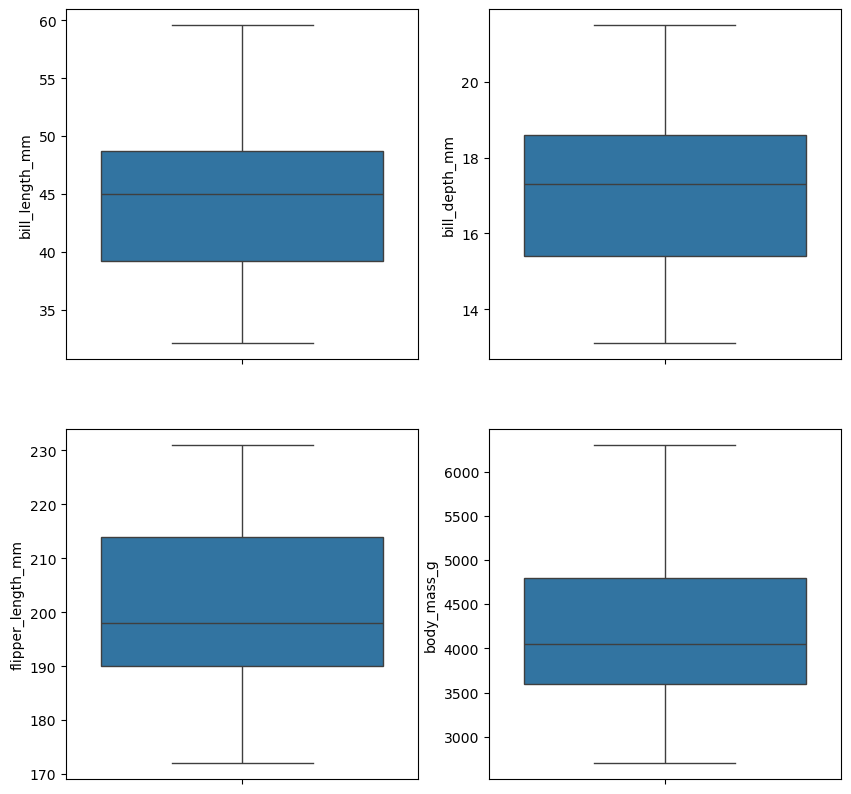

In [18]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

# create 4 box plots on the training datasets of the 4 numerical columns
sns.boxplot(data=X_penguins_train, y=numeric_cols[0], ax=ax[0,0])
sns.boxplot(data=X_penguins_train, y=numeric_cols[1], ax=ax[0,1])
sns.boxplot(data=X_penguins_train, y=numeric_cols[2], ax=ax[1,0])
sns.boxplot(y=y_penguins_train, ax=ax[1,1])

## One-Hot Encoding (Penguins 'species', 'island', 'sex')

The 'species' feature in the penguins dataset is categorical and nominal (values: Adelie, Chinstrap, Gentoo)
The same applies for 'island' (values: Torgersen, Biscoe, Dream) and 'sex' (values: MALE, FEMALE, Unknown)

There is no natural order between these categories, so ordinal encoding is inappropriate — assigning numbers would incorrectly imply a ranking.

One-hot encoding creates binary columns (dummy variables) for each species, clearly indicating the presence (1) or absence (0) of that category. One-hot will not contribute to feature explosion, since the number of unique values of the 'species' feature is small.

In [19]:
# create OneHotEncoder to be applied on the aforementioned categorical nomical features
onehot_encoder = None
# fit/transform the train dataset
X_penguins_train = None
# transform the text dataset
X_penguins_test = None

# print the 5 first rows of the training dataset
X_penguins_train.head()

,species_Adelie,species_Gentoo,species_Chinstrap,island_Biscoe,island_Torgersen,island_Dream,bill_length_mm,bill_depth_mm,flipper_length_mm,sex_MALE,sex_Unknown,sex_FEMALE
115,1,0,0,1,0,0,42.7,18.3,196.0,1,0,0
8,1,0,0,0,1,0,34.1,18.1,193.0,0,1,0
138,1,0,0,0,0,1,37.0,16.5,185.0,0,0,1
333,0,1,0,1,0,0,51.5,16.3,230.0,1,0,0
305,0,1,0,1,0,0,50.8,17.3,228.0,1,0,0


## Cyclical Encoding (Sales 'hour')

The datetime feature itself in the sales dataset is not directly usable. The raw datetime is a single complex value — models can’t easily interpret it. By breaking it down into meaningful components (like hour, day, month), we make it usable as features. Sales often follow daily patterns. Many businesses have rush hours (peaks) and quiet hours (lows) during the day. For example, sales might be highest around noon or early evening, and lowest at night. In this example, we decide to create a new hour feature out of the datetime feature. By including hour, the model can learn time-based trends and make more accurate predictions (e.g., higher expected sales at 13:00 than at 07:00).

The hour feature in the artificial sales dataset is cyclical: after 23 comes 0.

Using raw numeric values (0–23) would mislead distance-based algorithms: e.g., 0 and 23 appear far apart numerically, but they are actually close in time.

Cyclical encoding maps the hour onto a unit circle using sine and cosine:
* Preserves the cyclical nature of time
* Allows models to correctly interpret proximity between hours (e.g., 23 and 0 are close)
Works for any time-based feature like hours, months, or days of the week.

**Redundant columns**

Once we create the hour_sin and hour_cos features, the original numeric hour column is redundant. Keeping it could confuse models, as it introduces linear distance that contradicts the cyclical encoding.

Beyond hour, we can extract other time-based components (e.g., hour, day, month, year). Once all useful features are extracted from a datetime column and converted to cyclical, the original datetime column may no longer provide additional information for the model. Keeping it is redundant and may increase memory usage or confuse algorithms that cannot handle datetime objects directly.

Best practice: drop the redundant column(s) unless you plan to extract more features or need it for reference/merging datasets.

In [20]:
# Apply all needed steps only on the training dataset 
# (exactly the same steps need also be applied on validation and test datasets but are omitted here)

# create a new column called 'hour', which contains the hour extracted from the datetime
X_sales_train['hour'] = X_sales_train['datetime'].dt.hour
# create new columns 'hour_sin' and 'hour_cos' which can potentially replace the 'hour' column
X_sales_train['hour_sin'] = None
X_sales_train['hour_cos'] = None

# drop columns datetime and hour
X_sales_train = X_sales_train.drop(columns=['datetime', 'hour'])

# print first 5 rows
X_sales_train.head()

,store,item,hour_sin,hour_cos
84,A,Apple,-1.361666e-01,-0.990686
95,A,Orange,-2.449294e-16,1.000000
137,C,Apple,-9.976688e-01,-0.068242
212,C,Orange,-7.308360e-01,0.682553
86,C,Apple,-6.310879e-01,-0.775711


##  Feature Scaling

Before moving further to feature scaling and unskewing it seems important (a) inspect the basic statistics of numerical columns and (b) to plot the distributions of the features/target variables because:

Basic statistics help:
1. Understand data distribution: .describe() shows mean, standard deviation, min, max, and quartiles — which helps you see how spread out or skewed each feature is.
2. Detect anomalies/outliers: Very large min–max ranges or extreme values might indicate outliers that can distort scaling.
3. Check for different scales: Seeing very different ranges across features confirms the need for scaling.
4. Spot potential data entry errors: Negative ages, impossible values, or unexpected zeros stand out quickly.
5. Plan appropriate preprocessing: For example, highly skewed data may need transformations (like Yeo-Johnson) before scaling.

Distribution plots help:
1. Understand the shape of the data
    * Histograms, KDE plots, or boxplots reveal skewness, outliers, and modality.
    * Helps decide whether transformations (log, Yeo-Johnson, etc.) are necessary.
2. Choose the right scaling method
    * Standardization (mean=0, std=1) works best for roughly Gaussian data.
    * Min-max scaling works for bounded ranges.
    * Robust scaling is better if there are extreme outliers.
3. Detect potential issues before modeling
    * Highly skewed features may dominate distance-based or gradient-based models.
    * Categorical features accidentally stored as numbers can be spotted.
4. Visual justification for preprocessing
    * Shows students why a particular scaling or unskewing method is chosen.
    * Makes the workflow more transparent and reproducible.

In [21]:
# print penguins basic statistics on the training dataset
None

,species_Adelie,species_Gentoo,species_Chinstrap,island_Biscoe,island_Torgersen,island_Dream,bill_length_mm,bill_depth_mm,flipper_length_mm,sex_MALE,sex_Unknown,sex_FEMALE
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,0.424908,0.369963,0.205128,0.494505,0.131868,0.373626,44.029670,17.105495,201.362637,0.487179,0.025641,0.487179
std,0.495237,0.483681,0.404537,0.500888,0.338969,0.484655,5.540987,1.982777,14.165656,0.500754,0.158352,0.500754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.100000,13.100000,172.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.200000,15.400000,190.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,17.300000,198.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,48.700000,18.600000,214.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,59.600000,21.500000,231.000000,1.000000,1.000000,1.000000


One-hot encoded features (created from species, island and sex):
* are binary columns (0 or 1) created by one-hot encoding the species feature.
* aready have the same scale (just two possible values).
* scaling them would distort their meaning — e.g. if we scaled 0/1 to 0.3/0.7, the values would lose their clear interpretation of absence (0) vs. presence (1).

Numerical features (bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g):
* are continuous numeric variables and, as seen in .describe(), they are in very different ranges:
    * bill_depth_mm is around 13–22
    * flipper_length_mm is around 170–230
    * body_mass_g is around 2700–6300
* Many machine learning algorithms (like gradient descent-based models, k-NN, SVM) work better when numerical features are on similar scales, because otherwise large-range features dominate the calculations.

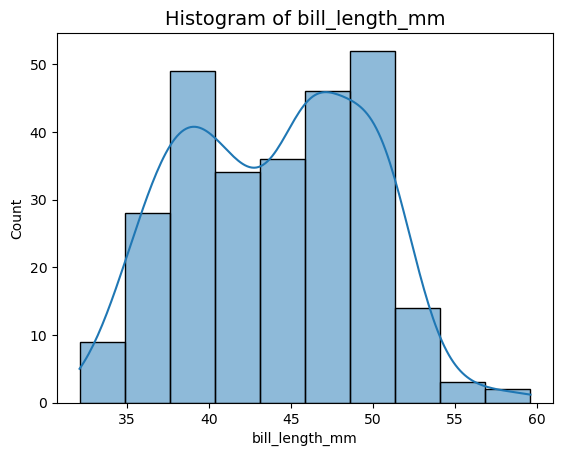

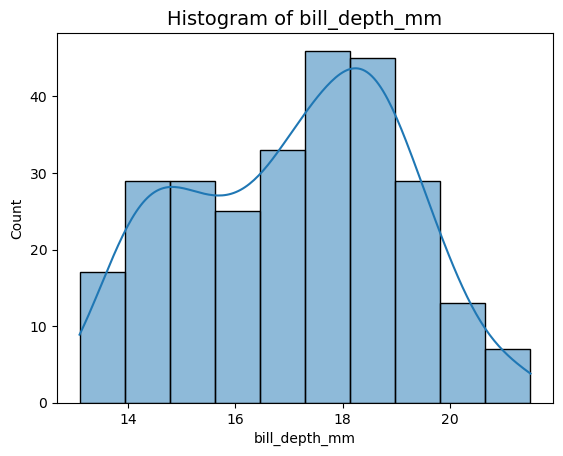

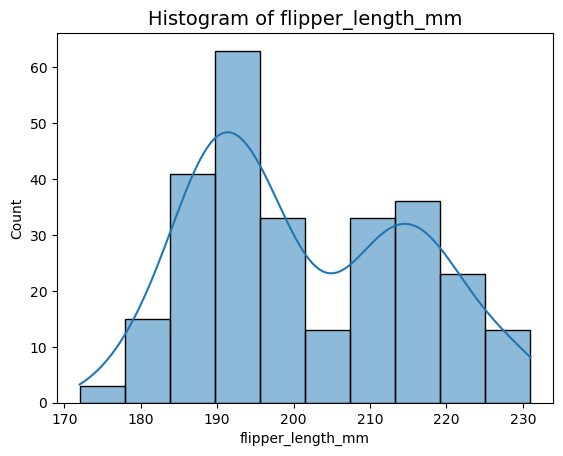

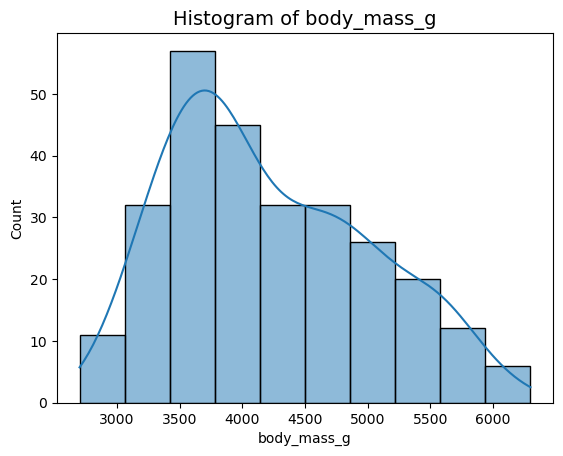

In [22]:
# Plot histograms for each numerical column (use the training dataset)
for col in numeric_cols:
    # 'body_mass_g' is in y_penguins_train dataset
    if col == 'body_mass_g':
        fig, ax = plt.subplots()
        sns.histplot(y_penguins_train, kde=True)
        ax.set_title(f'Histogram of {col}', fontsize=14)
        ax.set_xlabel(col)
    # the rest are in X_penguins_train dataset
    else:
        fig, ax = plt.subplots()
        sns.histplot(X_penguins_train[col], kde=True)
        ax.set_title(f'Histogram of {col}', fontsize=14)
        ax.set_xlabel(col)

If body_mass_g is the target variable, then it should be kept separate from the feature set during preprocessing. We do not scale the target when scaling the features, because scaling is meant to make features comparable to each other, not the target and including the target in feature scaling pipelines can cause data leakage. We will later apply a separate transformation to the target (like Yeo-Johnson or Box-Cox) since it seems to be right skewed.

The rest three numerical features are not Gaussian-like and don’t contain significant outliers. Therefore, using Standard Scaler (which assumes approximately normal distributions) is not appropriate. Instead, we will apply either a Min-Max Scaler or a Robust Scaler:
* Min-Max is useful to bring all features into the same [0,1] range.
* Robust is preferred if we detect any mild outliers, as it uses medians and IQR.

In [23]:
# Check for outliers, i.e. values outside of the 'whiskers'
# DON'T CHANGE ANYTHING IN THIS CELL
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']

for col in num_cols:
    Q1 = X_penguins_train[col].quantile(0.25)
    Q3 = X_penguins_train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = X_penguins_train[(X_penguins_train[col] < lower) | (X_penguins_train[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

bill_length_mm: 0 outliers
bill_depth_mm: 0 outliers
flipper_length_mm: 0 outliers


If the number of outliers are 0 or very low, there are no significant outliers. This is the case, therefore, we will use Min-Max Scaler (that keeps original shape, good for bounded range). If several outliers existed, then we would use Robust Scaler (less affected by extreme values).

In [24]:
# initiate MinMaxScaler object
scaler = MinMaxScaler()
# fit/transform training dataset
X_penguins_train[['bill_length_mm','bill_depth_mm','flipper_length_mm']] = scaler.fit_transform(
    X_penguins_train[['bill_length_mm','bill_depth_mm','flipper_length_mm']]
)
# transform test dataset
X_penguins_test[['bill_length_mm','bill_depth_mm','flipper_length_mm']] = None

# print the first 5 rows of the training dataset
X_penguins_train.head()

,species_Adelie,species_Gentoo,species_Chinstrap,island_Biscoe,island_Torgersen,island_Dream,bill_length_mm,bill_depth_mm,flipper_length_mm,sex_MALE,sex_Unknown,sex_FEMALE
115,1,0,0,1,0,0,0.385455,0.619048,0.406780,1,0,0
8,1,0,0,0,1,0,0.072727,0.595238,0.355932,0,1,0
138,1,0,0,0,0,1,0.178182,0.404762,0.220339,0,0,1
333,0,1,0,1,0,0,0.705455,0.380952,0.983051,1,0,0
305,0,1,0,1,0,0,0.680000,0.500000,0.949153,1,0,0


## Unskewing Target Variable (Yeo-Johnson)

As shown above, the body_mass_g (the target variable) is right skewed. Here, we will apply Yeo Johnson transformation to convert the distribution to be more symmetric and closer to a Gaussian.

In [25]:
# Apply Yeo-Johnson unskewing tranformation
pt = None
# fit/transform on training dataset
# we need to use .to_frame() to convert y_train/y_test which are Pandas Series to Pandas DataFrame which is required by the PowerTransformer
y_penguins_train = None
# transform on test dataset
y_penguins_test = None

Text(0.5, 0, 'Body Mass (g)')

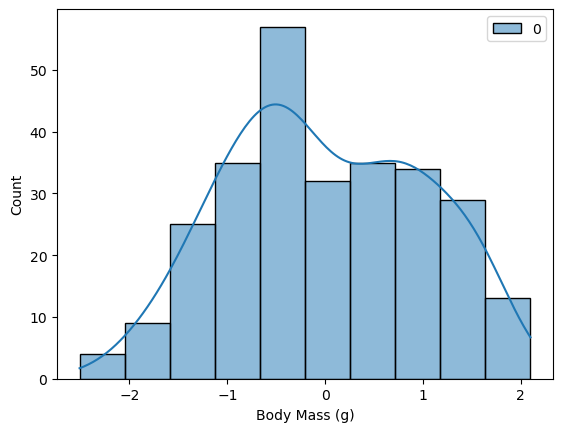

In [26]:
# plot the body_mass_g (training)
fig, ax = plt.subplots()
sns.histplot(data=y_penguins_train, kde=True)
ax.set_xlabel('Body Mass (g)')

After applying the Yeo-Johnson transformation on the body_mass_g feature, the distribution appears more symmetric and closer to a Gaussian (normal) shape. This helps meet the normality assumption of many machine learning algorithms and can improve their performance.

Text(0.5, 0, 'Body Mass (g)')

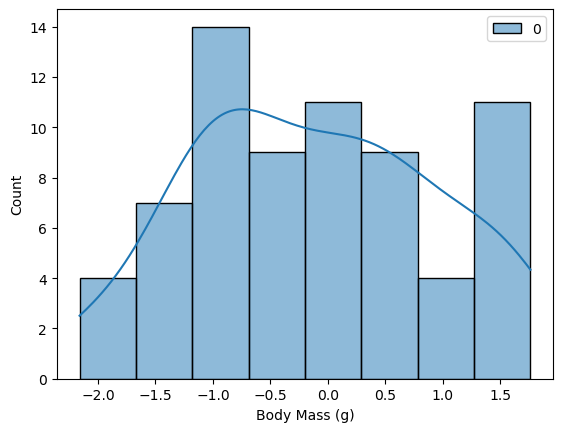

In [27]:
# plot the body_mass_g (test)
fig, ax = plt.subplots()
sns.histplot(data=y_penguins_test, kde=True)
ax.set_xlabel('Body Mass (g)')